In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import glob


In [2]:
filenames = glob.glob("dataset/*/*.jpg")
print(len(filenames))

data = []
labels = []

for idx, img_path in enumerate(filenames):
    label = img_path.split(os.path.sep)[-2]

    img = image.load_img(img_path, target_size=(224, 224), interpolation="nearest")
    img = image.img_to_array(img)
    img = preprocess_input(img) ## using mobilenet_v2

    # update the data and labels lists, respectively
    labels.append(label)
    data.append(img)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

3762


In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# Train 70%
# Test  15%
# Val   15%
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=42)
(testX, valX, testY, valY) = train_test_split(testX, testY, test_size=0.50, stratify=testY, random_state=42)

print('train :', len(trainX), len(trainY))
print('test  :', len(testX), len(testY))
print('val   :', len(valX), len(valY))

train : 2633 2633
test  : 564 564
val   : 565 565


In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
												rotation_range=20,
												zoom_range=0.15,
												width_shift_range=0.2,
												height_shift_range=0.2,
												shear_range=0.15,
												horizontal_flip=True,
												fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = InceptionV3(weights="imagenet", 
												include_top=False,
												input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", 
							optimizer=opt,
							metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
						aug.flow(trainX, trainY, batch_size=BS),
						steps_per_epoch=len(trainX) // BS,
						validation_data=(testX, testY),
						validation_steps=len(testX) // BS,
						epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/Users/thana/Workspace/Class/image_project/project/env/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-05-02 09:59:02.484430: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20
82/82 [==============================] - 81s 967ms/step - loss: 0.1449 - accuracy: 0.9558 - val_loss: 0.0183 - val_accuracy: 0.9947
Epoch 2/20
82/82 [==============================] - 88s 1s/step - loss: 0.0758 - accuracy: 0.9746 - val_loss: 0.0107 - val_accuracy: 0.9947
Epoch 3/20
82/82 [==============================] - 92s 1s/step - loss: 0.0572 - accuracy: 0.9800 - val_loss: 0.0142 - val_accuracy: 0.9929
Epoch 4/20
82/82 [==============================] - 90s 1s/step - loss: 0.0493 - accuracy: 0.9835 - val_loss: 0.0177 - val_accuracy: 0.9911
Epoch 5/20
82/82 [==============================] - 94s 1s/step - loss: 0.0548 - accuracy: 0.9835 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 6/20
82/82 [==============================] - 94s 1s/step - loss: 0.0508 - accuracy: 0.9827 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 7/20
82/82 [==============================] - 95s 1s/step - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.0069 - val_accuracy: 0.9982
Epoch 8/20
82/82 

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       275
without_mask       1.00      1.00      1.00       289

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564

[INFO] saving mask detector model...


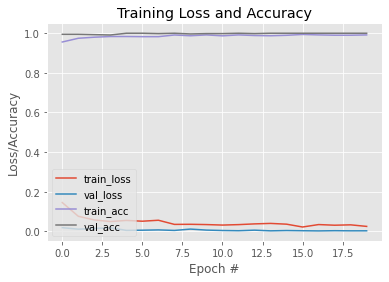

In [7]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model_InceptionV3", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output_InceptionV3")